In [1]:
# Programming Assignment #4
# Hanyu Feng 
# Student ID:452106
# T81-558: Application of Deep Learning

import os
import sklearn
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.cross_validation import KFold
from scipy.stats import zscore
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow.contrib.learn as learn
from tensorflow.contrib.learn.python.learn.metric_spec import MetricSpec
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import shutil
import time
ENCODING = 'utf-8'

path = "./final project"

# Encode a text field to dummy variables
def encode_text_dummy(df,name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name,x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode a text field to a single index value
def encode_text_index(df,name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Encode a numeric field to Z-Scores
def encode_numeric_zscore(df,name,mean=None,sd=None):
    if mean is None:
        mean = df[name].mean()
    if sd is None:
        sd = df[name].std()
    if sd ==0:
        df[name] = df[name]
    else :
        df[name] = (df[name]-mean)/sd
    


# Encode a numeric field to fill missing values with the median.
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)

# Convert a dataframe to x/y suitable for training.
def to_xy(df,target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    return df.as_matrix(result),df[target]



def get_model_dir(name,erase):
    base_path = os.path.join("./final project","dnn")
    model_dir = os.path.join(base_path,name)
    os.makedirs(model_dir,exist_ok=True)
    if erase and len(model_dir)>4 and os.path.isdir(model_dir):
        shutil.rmtree(model_dir,ignore_errors=True) # be careful, this deletes everything below the specified path
    return model_dir


# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y_test, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()


/Users/hanyufeng/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
print("***Final Project***")
tf.logging.set_verbosity(tf.logging.ERROR)
# Use the data to predict which set should the data be
# This is a Classification problem
#   https://archive.ics.uci.edu/ml/datasets/Liver+Disorders

# Read the data
# Liver disorder data set is selected
filename = os.path.join(path,"bupa.csv")
df = pd.read_csv(filename,na_values=['NA','?'])

# The first 5 variables are all blood tests which are thought to be sensitive to liver 
#disorders that might arise from excessive alcohol consumption. 
# Each line in the bupa.data file constitutes the record of a single male individual. 
# It appears that drinks>5 is some sort of a selector on this database. 
# See the PC/BEAGLE User's Guide for more information.

# 1. mcv mean corpuscular volume 
# 2. alkphos alkaline phosphotase 
# 3. sgpt alamine aminotransferase 
# 4. sgot aspartate aminotransferase 
# 5. gammagt gamma-glutamyl transpeptidase 
# 6. drinks number of half-pint equivalents of alcoholic beverages drunk per day 
# 7. selector field used to split data into two sets



# Preprocess the data
missing_median(df,'mcv')
encode_numeric_zscore(df,'mcv')
missing_median(df,'alkphos')
encode_numeric_zscore(df,'alkphos')
missing_median(df,'sgpt')
encode_numeric_zscore(df,'sgpt')
missing_median(df,'sgot')
encode_numeric_zscore(df,'sgot')
missing_median(df,'gammagt')
encode_numeric_zscore(df,'gammagt')
missing_median(df,'drinks')
encode_numeric_zscore(df,'drinks')
#encode_text_index(trainDF,'drinks')
#encode_text_index(df,'selector')

classnum = encode_text_index(df,'selector')
num_classes = len(classnum)

# Split the data
x,y = to_xy(df,'selector')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(
x, y, test_size=0.2,random_state = 45)

# Get/clear a directory to store the neural network to
model_dir = get_model_dir('bupa',True)

# Choose an optimizer
#opt=tf.train.AdamOptimizer(learning_rate=0.1)

# Create a deep neural network with 3 hidden layers
feature_columns = [tf.contrib.layers.real_valued_column("", dimension=x.shape[0])]
classifier = learn.DNNClassifier(
    model_dir= model_dir, 
    #optimizer=opt,
    config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1),
    hidden_units=[10,20,5], n_classes=num_classes, feature_columns=feature_columns)



# Early stopping
validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
    x_test,
    y_test,
    every_n_steps=50,
    early_stopping_metric="loss",
    early_stopping_metric_minimize=True,
    early_stopping_rounds=500)

start_time = time.time()

# Fit/train neural network
classifier.fit(x_train, y_train, monitors=[validation_monitor],steps=10000)

# Calculate the time used for trainning
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

# Output the best step
print("Best step: {}, Last successful step: {}".format(
validation_monitor.best_step,validation_monitor._last_successful_step))

# Don't display numpy in scientific notation
pred = list(classifier.predict(x_test, as_iterable=True))
score = metrics.accuracy_score(y_test, pred)
print("Final accuracy: {}".format(score))



***Final Project***
Elapsed time: 0:00:34.55
Best step: 150, Last successful step: 650
Final accuracy: 0.7391304347826086


Confusion matrix, without normalization
[[107  38]
 [ 24 176]]
Normalized confusion matrix
[[ 0.74  0.26]
 [ 0.12  0.88]]


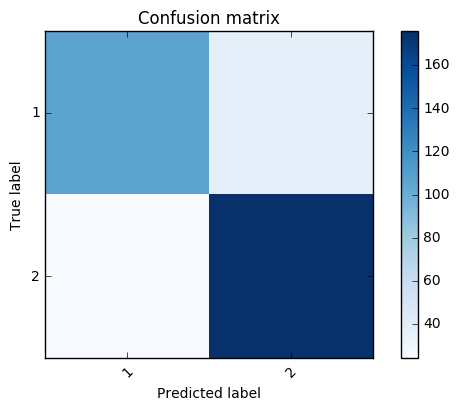

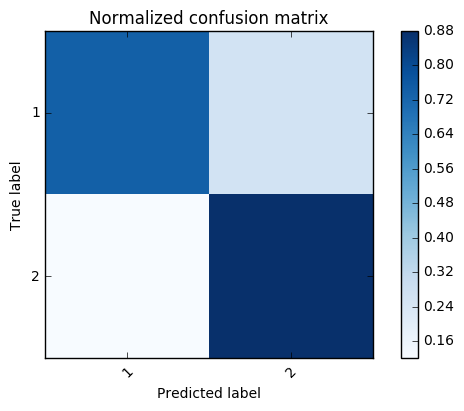

In [5]:
pred = list(classifier.predict(x, as_iterable=True))
    
# Compute confusion matrix
cm = confusion_matrix(y, pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm,classnum)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, classnum, title='Normalized confusion matrix')
plt.show()

In [ ]:
#    Final Project Report

#   1. For the input variables, I would encode them with zscore, 
# for each input variable is a numeric variable,zscore provides a 
# centered field with which the neural network could do well.

#   2. For this project, I was going to predict the classification 
# of "selector" to represent which set the data shouldbe assigned to. 
# So, to measure the result of classification, the accuracy would be 
# a reasonable measurement.

#   3. Since the variable "selector" represents which set the data
# should be assigned to, the output of the deep neural network is 
# a class rather than a specific number. Therefore, the model is a 
# classification.

#   4. As for the dataset "bupa", there is no missing data. If there 
# were some numeric missing data, the solution would be using the 
# method "missing_median" to full up the missing data with the median
# of the column.

#   5. The difficulty in the dataset would be in the column of "drinks". 
# This column represents the number of half-pint equivalents of alcoholic 
# beverages drunk per day, which could be some uncontinuous numeric value 
# with step. So, when encoding the column of "drinks", it could be taken as 
# numeric value or just some level of drink. Thus either zscore or index 
# could be used, it depends on how we interpret the meaning of "drinks". 
# Another difficulty in the dataset is that the volumn of the date is not 
# large enough to be seperated into training and validation. 
